In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import requests as r
from Bio import SeqIO
from io import StringIO
from typing import List, Tuple, Union

# Setting up local details:
# This should be the location of the checkout of the FS-Mol repository:
FS_MOL_CHECKOUT_PATH = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol")
FS_MOL_DATASET_PATH = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol", "datasets")

os.chdir(FS_MOL_CHECKOUT_PATH)
sys.path.insert(0, FS_MOL_CHECKOUT_PATH)

#from fs_mol.utils.protein_utils import get_protein_sequence, get_target_chembl_id

In [2]:
# import libraries from FS-Mol:
from fs_mol.data import FSMolTask

In [2]:
from chembl_webresource_client.new_client import new_client

def get_target_chembl_id(assay_chembl_id):
    assay = new_client.assay
    assay_result = assay.get(assay_chembl_id)
    if "target_chembl_id" in assay_result:
        target_chembl_ids = assay_result["target_chembl_id"]
        return target_chembl_ids
    return None


In [3]:
def get_protein_accession(target_chembl_id: str):
    """Returns the target protein accesion id for a given target chembl id.
    This id can be used to retrieve the protein sequence from the UniProt.

    Args:
        target_chembl_id: Chembl id of the target.
    """
    target = new_client.target
    target_result = target.get(target_chembl_id)
    if "target_components" in target_result:
        return target_result["target_components"][0]['accession']
    else:
        return None

In [4]:
def get_protein_sequence(protein_accession: str):
    """Returns the protein sequence for a given protein accession id.
    
    Args:
        protein_accession: Accession id of the protein.
    """
    cID= protein_accession
    baseUrl="http://www.uniprot.org/uniprot/"
    currentUrl=baseUrl+cID+".fasta"
    response = r.post(currentUrl)
    cData=''.join(response.text)

    Seq=StringIO(cData)
    pSeq=list(SeqIO.parse(Seq,'fasta'))
    return pSeq

In [3]:
target_df = pd.read_csv(os.path.join(FS_MOL_DATASET_PATH, "targets", "target_info.csv"))
target_train_df = pd.read_csv(os.path.join(FS_MOL_DATASET_PATH, "targets", "train_proteins.csv"))
target_valid_df = pd.read_csv(os.path.join(FS_MOL_DATASET_PATH, "targets", "valid_proteins.csv"))
target_test_df = pd.read_csv(os.path.join(FS_MOL_DATASET_PATH, "targets", "test_proteins.csv"))

In [12]:
assay_chembl_ids = target_df['chembl_id'].tolist()
assay_train_chembl_ids = target_train_df['chembl_id'].tolist()
assay_valid_chembl_ids = target_valid_df['chembl_id'].tolist()
assay_test_chembl_ids = target_test_df['chembl_id'].tolist()

In [13]:
print(len(assay_chembl_ids))
print(len(assay_train_chembl_ids))
print(len(assay_valid_chembl_ids))
print(len(assay_test_chembl_ids))


27004
4938
40
157


In [15]:
target_train_chembl_ids = [get_target_chembl_id(assay_chembl_id) for assay_chembl_id in tqdm(assay_train_chembl_ids)]
target_valid_chembl_ids = [get_target_chembl_id(assay_chembl_id) for assay_chembl_id in tqdm(assay_valid_chembl_ids)]
target_test_chembl_ids = [get_target_chembl_id(assay_chembl_id) for assay_chembl_id in tqdm(assay_test_chembl_ids)]

100%|██████████| 157/157 [00:01<00:00, 137.25it/s]


In [16]:
print(np.array([isinstance(item, str) for item in target_train_chembl_ids]).sum())
print(np.array([isinstance(item, str) for item in target_valid_chembl_ids]).sum())
print(np.array([isinstance(item, str) for item in target_test_chembl_ids]).sum())


4938
40
157


In [17]:
target_train_df['target_chembl_id'] = target_train_chembl_ids
target_valid_df['target_chembl_id'] = target_valid_chembl_ids
target_test_df['target_chembl_id'] = target_test_chembl_ids

In [19]:
print(len(target_train_chembl_ids))
print(len(target_valid_chembl_ids))
print(len(target_test_chembl_ids))


4938
40
157


In [29]:
target_train_df.to_csv(os.path.join(FS_MOL_DATASET_PATH, "targets", "train_proteins.csv"), index=False)
target_valid_df.to_csv(os.path.join(FS_MOL_DATASET_PATH, "targets", "valid_proteins.csv"), index=False)
target_test_df.to_csv(os.path.join(FS_MOL_DATASET_PATH, "targets", "test_proteins.csv"), index=False)

In [22]:
target_train_accession = [get_protein_accession(target_chembl_id) for target_chembl_id in tqdm(target_train_chembl_ids)]
target_valid_accession = [get_protein_accession(target_chembl_id) for target_chembl_id in tqdm(target_valid_chembl_ids)]
target_test_accession = [get_protein_accession(target_chembl_id) for target_chembl_id in tqdm(target_test_chembl_ids)]

100%|██████████| 157/157 [00:01<00:00, 114.36it/s]


In [24]:
print(len(target_train_accession))
print(len(target_valid_accession))
print(len(target_test_accession))

4938
40
157


In [25]:
target_train_df['target_accession_id'] = target_train_accession
target_valid_df['target_accession_id'] = target_valid_accession
target_test_df['target_accession_id'] = target_test_accession

In [15]:
target_train_seq = [get_protein_sequence(target_id) for target_id in tqdm(target_train_df['target_accession_id'])]
target_valid_seq = [get_protein_sequence(target_id) for target_id in tqdm(target_valid_df['target_accession_id'])]
target_test_seq =  [get_protein_sequence(target_id) for target_id in tqdm(target_test_df['target_accession_id'])]


100%|██████████| 157/157 [01:07<00:00,  2.33it/s]


In [17]:
print(len(target_train_seq))
print(len(target_valid_seq))
print(len(target_test_seq))

4938
40
157


In [27]:
train_seq = [str(seq[0].seq) for seq in target_train_seq]
valid_seq = [str(seq[0].seq) for seq in target_valid_seq]
test_seq = [str(seq[0].seq) for seq in target_test_seq]

In [23]:
target_train_df['target_seq'] = target_train_seq
target_valid_df['target_seq'] = target_valid_seq
target_test_df['target_seq'] = target_test_seq

In [3]:
# Plotting configuration:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"

plt.rcParams.update(
    {
        "font.size": 20,
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
    }
)

In [ ]:
plt.rc("axes", labelsize=24)  # fontsize of the x and y labels
plt.rc("legend", fontsize=22)  # fontsize of the legend
plt.rc("xtick", labelsize=22)
plt.rc("ytick", labelsize=22)

train_seq_len = [len(str(seq[0].seq)) for seq in target_train_df['target_seq']]
valid_seq_len = [len(str(seq[0].seq)) for seq in target_valid_df['target_seq']]
test_seq_len = [len(str(seq[0].seq)) for seq in target_test_df['target_seq']]

fig, ax = plt.subplots(3, 1, figsize=(15, 20))

ax[0].hist(train_seq_len, bins=50)
ax[1].hist(valid_seq_len, bins=10)
ax[2].hist(test_seq_len, bins=20)

[ax[i].set(xlim=(0.0, 4000.0)) for i in range(3)]
[ax[i].set_xlabel("Protein Sequence Length") for i in range(3)]

plt.show()

In [38]:
train_sequences = [item[0] for item in target_train_df['target_seq']]
valid_sequences = [item[0] for item in target_valid_df['target_seq']]
test_sequences = [item[0] for item in target_test_df['target_seq']]

with open(os.path.join(FS_MOL_DATASET_PATH, "targets", "test_proteins.fasta"), "w") as output_handle:
    SeqIO.write(test_sequences, output_handle, "fasta")


In [35]:
[item[0] for item in target_train_df['target_seq']]

[SeqRecord(seq=Seq('MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYKQSIAQRAR...HWC'), id='sp|Q00975|CAC1B_HUMAN', name='sp|Q00975|CAC1B_HUMAN', description='sp|Q00975|CAC1B_HUMAN Voltage-dependent N-type calcium channel subunit alpha-1B OS=Homo sapiens OX=9606 GN=CACNA1B PE=1 SV=1', dbxrefs=[]),
 SeqRecord(seq=Seq('MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYKQSIAQRAR...HWC'), id='sp|Q00975|CAC1B_HUMAN', name='sp|Q00975|CAC1B_HUMAN', description='sp|Q00975|CAC1B_HUMAN Voltage-dependent N-type calcium channel subunit alpha-1B OS=Homo sapiens OX=9606 GN=CACNA1B PE=1 SV=1', dbxrefs=[]),
 SeqRecord(seq=Seq('MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYKQSIAQRAR...HWC'), id='sp|Q00975|CAC1B_HUMAN', name='sp|Q00975|CAC1B_HUMAN', description='sp|Q00975|CAC1B_HUMAN Voltage-dependent N-type calcium channel subunit alpha-1B OS=Homo sapiens OX=9606 GN=CACNA1B PE=1 SV=1', dbxrefs=[]),
 SeqRecord(seq=Seq('MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYKQSIAQRAR...HWC'), id='sp|Q00975|CAC1B_HUMAN', nam

In [57]:
import torch
import esm

def esm_repr(data: List[Tuple[str, str]]) -> List[torch.Tensor]:
    # Load ESM-2 model
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    batch_converter = alphabet.get_batch_converter()
    model.eval()  # disables dropout for deterministic results
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=False)
    token_representations = results["representations"][33]

    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

    return sequence_representations

/home/hfooladi/miniconda3/envs/pytorch1.12_py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
train_seq = list(zip(target_train_df['chembl_id'], target_train_df['target_seq']))
valid_seq = list(zip(target_valid_df['chembl_id'], target_valid_df['target_seq']))
test_seq = list(zip(target_test_df['chembl_id'], target_test_df['target_seq']))

In [69]:
len(test_seq)

157

In [ ]:

#train_seq_repr = esm_repr(train_seq)
#valid_seq_repr = esm_repr(valid_seq)
test_seq_repr_1 = esm_repr(test_seq[:50]) 

In [ ]:
with open(os.path.join(FS_MOL_DATASET_PATH, "targets", "train_proteins.fasta"), "r") as f, open(os.path.join(FS_MOL_DATASET_PATH, "targets", "trains_proteins.fasta"), "w") as g:
    all = []
    records = SeqIO.parse(f, 'fasta')
    i = 0
    for record in records:
        if record.id not in all:
            all.append(record.id)
            record.description = record.id
        else:
            all.append(record.id + '_' + str(i))
            record.description = all[-1]
            record.id = all[-1]

            i += 1
        
        SeqIO.write(record, g, 'fasta')
    
print(all)



## Reading the Embedding from ESM

In [5]:
from pathlib import Path
import torch

ESM_EMBEDDING_PATH = os.path.join(FS_MOL_DATASET_PATH, "targets", "esm2_output")
 
train_esm = os.path.join(ESM_EMBEDDING_PATH, "train_proteins")
valid_esm = os.path.join(ESM_EMBEDDING_PATH, "valid_proteins")
test_esm = os.path.join(ESM_EMBEDDING_PATH, "test_proteins")


train_files = Path(train_esm).glob('*')
valid_files = Path(valid_esm).glob('*')
test_files = Path(test_esm).glob('*')


train_emb = []
valid_emb = []
test_emb = []

train_emb_label = []
valid_emb_label = []
test_emb_label = []

train_emb_tensor = torch.empty(0)
valid_emb_tensor= torch.empty(0)
test_emb_tensor = torch.empty(0)


for file in tqdm(train_files):
    train_emb.append(torch.load(file))
    train_emb_tensor = torch.cat((train_emb_tensor, train_emb[-1]['mean_representations'][33][None, :]), 0)
    train_emb_label.append(train_emb[-1]['label'])

for file in tqdm(valid_files):
    valid_emb.append(torch.load(file))
    valid_emb_tensor = torch.cat((valid_emb_tensor, valid_emb[-1]['mean_representations'][33][None, :]), 0)
    valid_emb_label.append(valid_emb[-1]['label'])

for file in tqdm(test_files):
    test_emb.append(torch.load(file))
    test_emb_tensor = torch.cat((test_emb_tensor, test_emb[-1]['mean_representations'][33][None, :]), 0)
    test_emb_label.append(test_emb[-1]['label'])

4938it [00:04, 1054.60it/s]
40it [00:00, 10677.96it/s]
157it [00:00, 1828.53it/s]


In [6]:
test_emb_tensor.shape

torch.Size([157, 1280])

In [6]:
train_ids = [item.split('|')[1] for item in train_emb_label]
valid_ids = [item.split('|')[1] for item in valid_emb_label]
test_ids =  [item.split('|')[1] for item in test_emb_label]

In [7]:
from collections import Counter
print(Counter(train_ids).most_common(5))
print(Counter(valid_ids).most_common(5))
print(Counter(test_ids).most_common(5))

[('P00533', 69), ('Q72547', 59), ('P00915', 57), ('P35968', 51), ('Q12809', 50)]
[('P97697', 1), ('Q00535', 1), ('Q9P1W9', 1), ('O97447', 1), ('P43367', 1)]
[('P61088', 1), ('P51452', 1), ('P55789', 1), ('P00761', 1), ('P33316', 1)]


In [8]:
assert train_emb_tensor.shape[0] == len(train_emb)
assert valid_emb_tensor.shape[0] == len(valid_emb)
assert test_emb_tensor.shape[0] == len(test_emb)

## Visualize protein embedding in Train, Validation and Test set

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE


light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"

plt.rcParams.update(
    {
        "font.size": 20,
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
    }
)

def visualize_tsne(dataset: torch.Tensor):
    """Visualizes the t-SNE embedding of the given dataset.
    
    dataset: torch.Tensor of shape (N, D) where N is the number of samples and D is the dimension of the embedding.
    """
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    tsne_embedding = tsne.fit_transform(dataset.detach().numpy())

    _, ax = plt.subplots(1, 1, figsize=(15, 15))
    ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=10, c=light_color)
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4938 samples in 0.001s...
[t-SNE] Computed neighbors for 4938 samples in 0.329s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4938
[t-SNE] Computed conditional probabilities for sample 2000 / 4938
[t-SNE] Computed conditional probabilities for sample 3000 / 4938
[t-SNE] Computed conditional probabilities for sample 4000 / 4938
[t-SNE] Computed conditional probabilities for sample 4938 / 4938
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.696815
[t-SNE] KL divergence after 1000 iterations: 0.224058


/tmp/ipykernel_129784/2950461577.py:28: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=10, c=light_color)


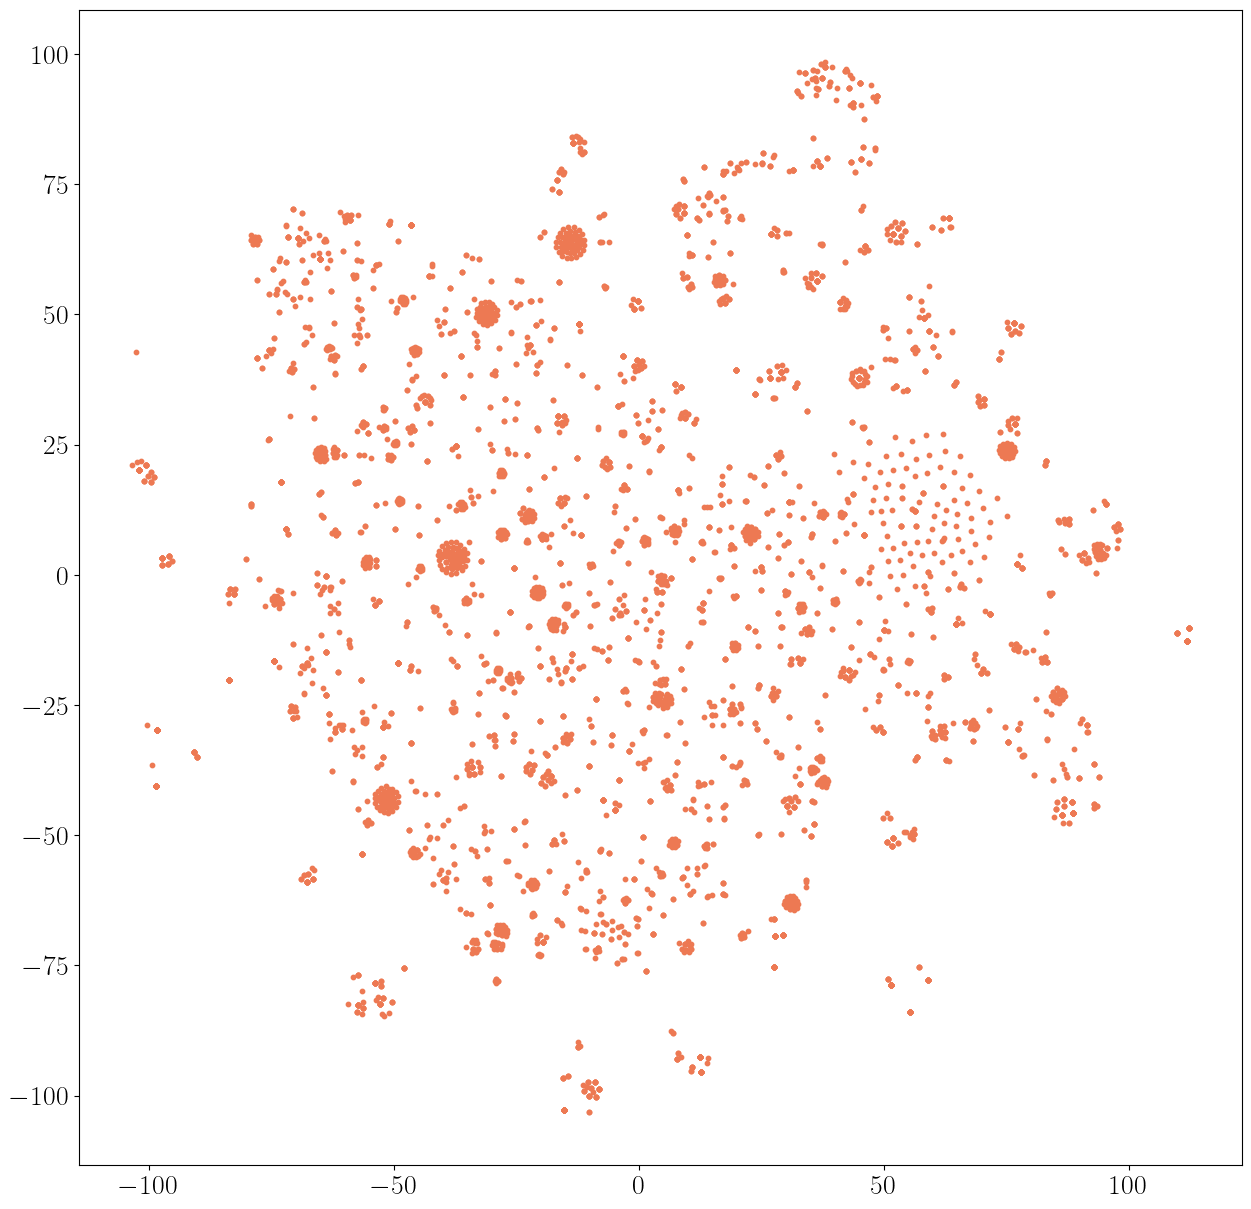

In [10]:
visualize_tsne(train_emb_tensor)

In [11]:
labels_to_idx = {'train': 0, 'valid': 1, 'test': 2}
idx_to_label = {0: 'Train', 1: 'Valid', 2: 'Test'}


labels = [labels_to_idx['train'] for _ in range(train_emb_tensor.shape[0])] + \
[labels_to_idx['valid'] for _ in range(valid_emb_tensor.shape[0])] + \
[labels_to_idx['test'] for _ in range(test_emb_tensor.shape[0])] 

labels_except_valid = [labels_to_idx['train'] for _ in range(train_emb_tensor.shape[0])] + \
[labels_to_idx['test'] for _ in range(test_emb_tensor.shape[0])]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5095 samples in 0.001s...
[t-SNE] Computed neighbors for 5095 samples in 0.279s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5095
[t-SNE] Computed conditional probabilities for sample 2000 / 5095
[t-SNE] Computed conditional probabilities for sample 3000 / 5095
[t-SNE] Computed conditional probabilities for sample 4000 / 5095
[t-SNE] Computed conditional probabilities for sample 5000 / 5095
[t-SNE] Computed conditional probabilities for sample 5095 / 5095
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.330444
[t-SNE] KL divergence after 1000 iterations: 0.253107


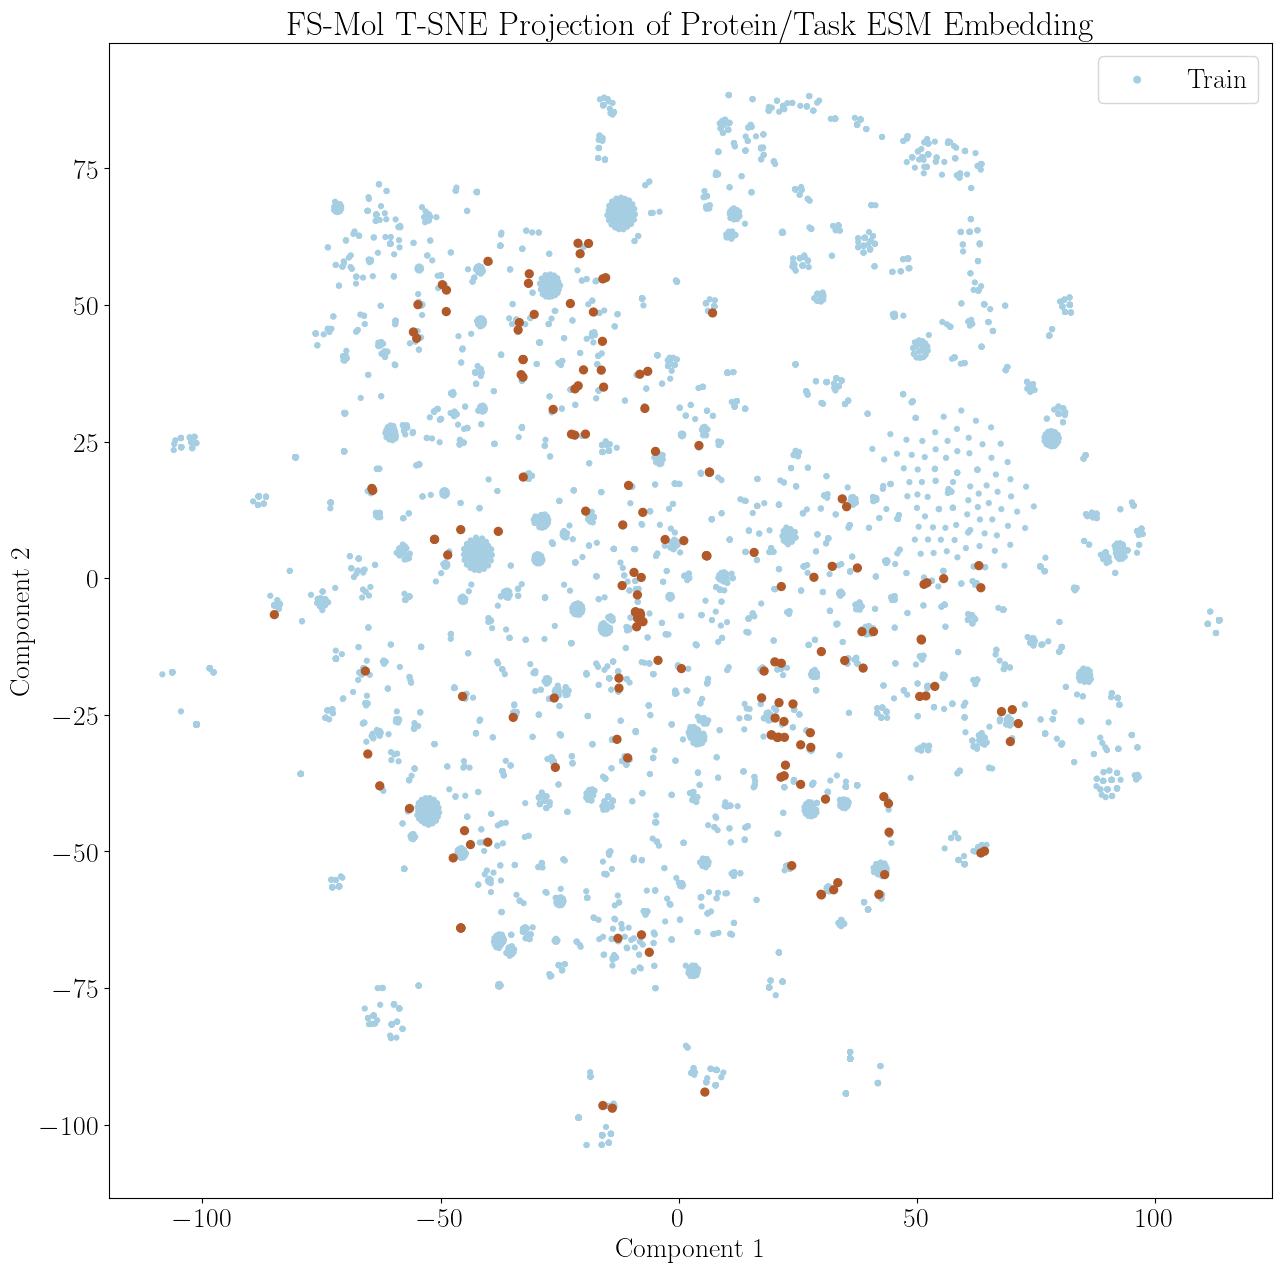

In [12]:
whole_embedding = torch.cat((train_emb_tensor, valid_emb_tensor, test_emb_tensor), 0)
whole_embedding_except_valid = torch.cat((train_emb_tensor, test_emb_tensor), 0)


tsne = TSNE(n_components=2, verbose=1, random_state=123)
tsne_embedding = tsne.fit_transform(whole_embedding_except_valid.detach().numpy())

size_map = [item*10 + 12 for item in labels_except_valid]

df = pd.DataFrame()
df["y"] = labels_except_valid
df["comp-1"] = tsne_embedding[:,0]
df["comp-2"] = tsne_embedding[:,1]

_, ax = plt.subplots(1, 1, figsize=(15, 15))

"""
sns.scatterplot(ax=ax, x="Component_1", y="Component_2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="FS-MOL T-SNE projection of Protein/Task ESM Embedding")
"""
ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=size_map, c=labels_except_valid, cmap='Paired')
ax.legend([idx_to_label[i] for i in range(3)])
ax.set_title("FS-Mol T-SNE Projection of Protein/Task ESM Embedding")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
plt.show()

## Compute Distance Between Train and Test Task (Protein Embedding)

In [13]:
# Train is a N_tr*D tensor and test is a N_te*D tensor
# The results is a N_tr*N_te tensor with the pairwise distances between train and test samples
train_test_dist_L2 = torch.cdist(train_emb_tensor, test_emb_tensor, p=2)

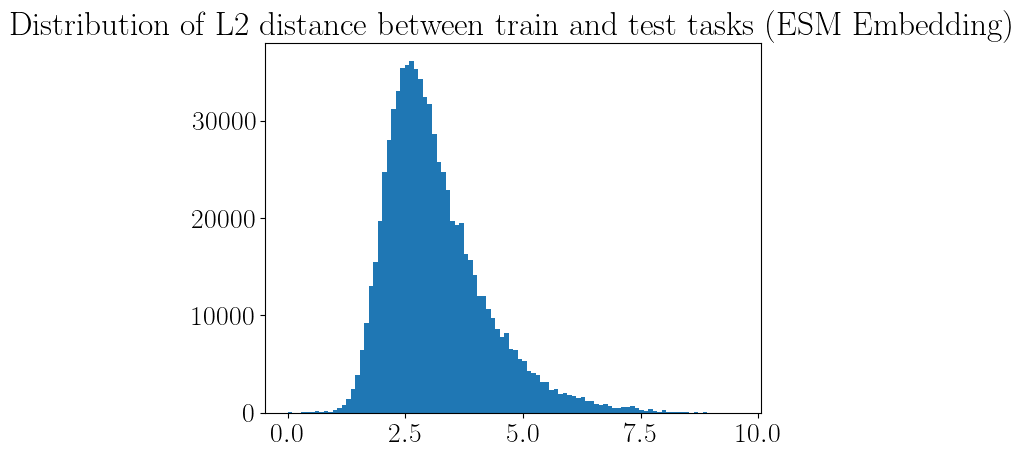

In [14]:
plt.hist(train_test_dist_L2.flatten().numpy(), bins=100)
plt.title("Distribution of L2 distance between train and test tasks (ESM Embedding)")
plt.show()

<Axes: >

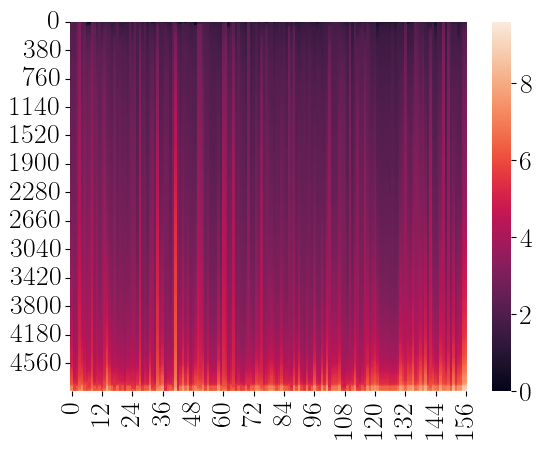

In [15]:
sns.heatmap(torch.sort(train_test_dist_L2, dim=0)[0])

In [16]:
def compute_task_hardness_protein(distance_matrix: torch.Tensor, k: int = 10) -> List[torch.Tensor]:
    """Computes the task hardness for each task in the dataset.
    
    Args:
        distance_matrix: N_tr*N_te tensor with the pairwise distances between train and test samples.
        k: Number of nearest neighbors to consider.
    """
    # Sort the distance matrix along the test dimension
    sorted_distance_matrix = torch.sort(distance_matrix, dim=0)[0]
    # Take the mean of the first k elements
    results=[]
    results.append(torch.mean(sorted_distance_matrix[:k, :], dim=0))
    results.append(torch.median(sorted_distance_matrix[:k, :], dim=0).values)
    return results

In [17]:
hardness_protien = compute_task_hardness_protein(train_test_dist_L2, k=100)

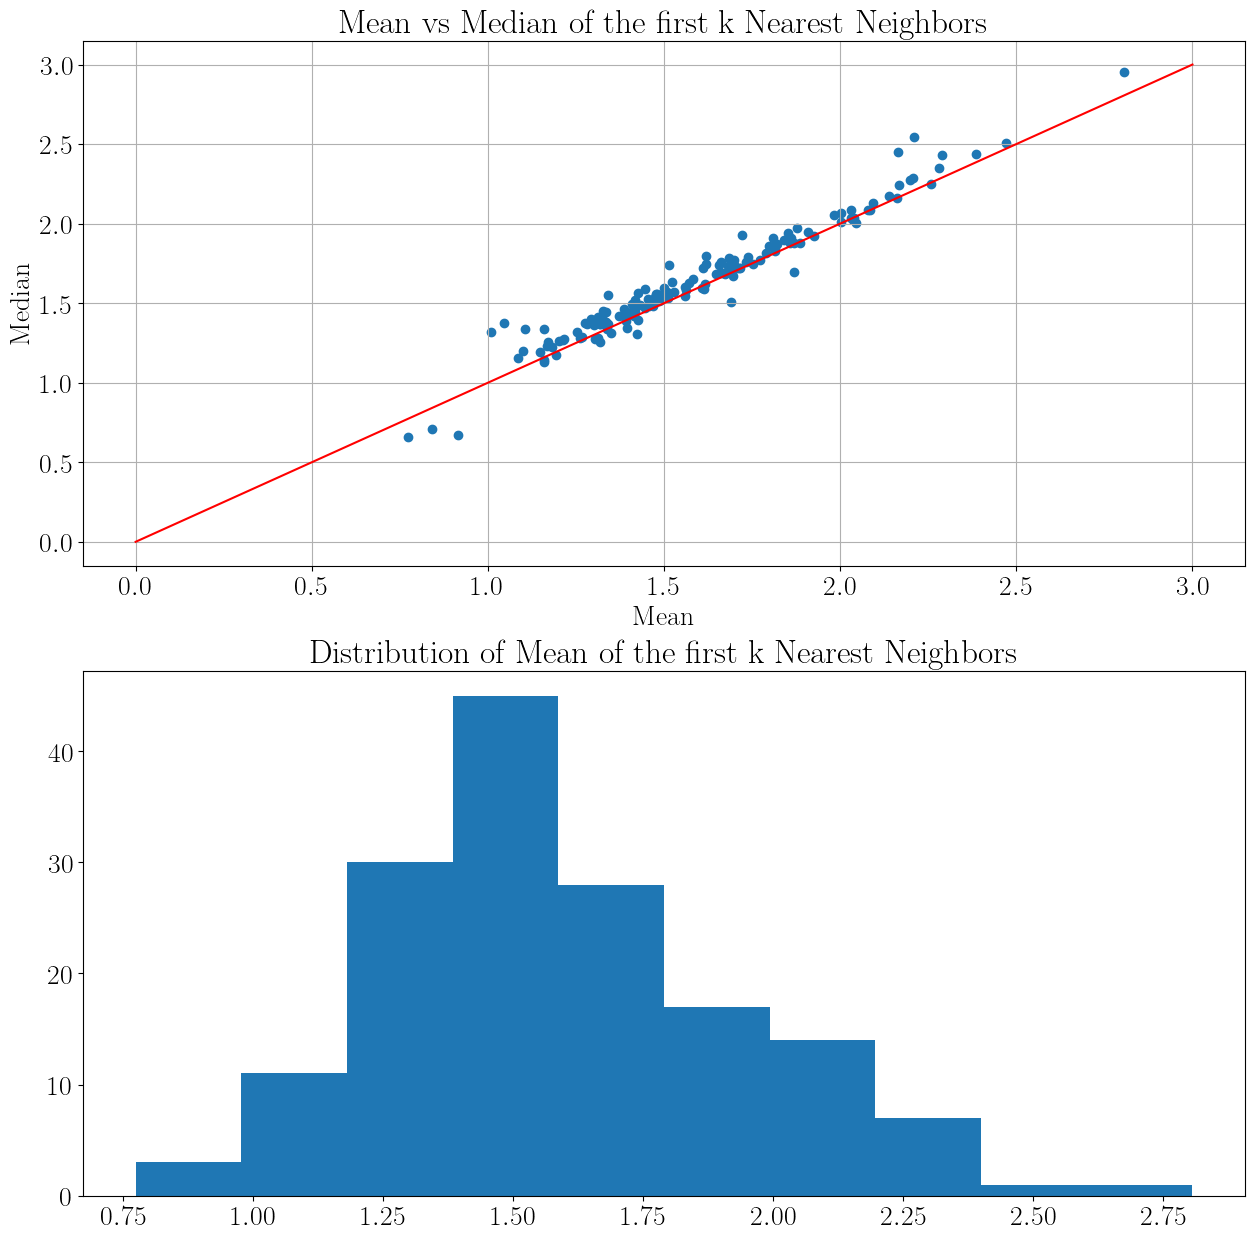

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
ax[0].scatter(hardness_protien[0], hardness_protien[1])
ax[0].add_line(plt.Line2D([0, 3], [0, 3], color='red'))
ax[0].set_title("Mean vs Median of the first k Nearest Neighbors")
ax[0].set_xlabel("Mean")
ax[0].set_ylabel("Median")
ax[0].grid(True)

ax[1].hist(hardness_protien[0].numpy(), bins=10)
ax[1].set_title("Distribution of Mean of the first k Nearest Neighbors")

plt.show()


In [19]:
a = []
for item in test_ids:
    a.append(target_test_df['chembl_id'][target_test_df['target_accession_id'] == item].item())

In [20]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [21]:
hardness_protien_mean_norm = normalize(hardness_protien[0])
hardness_protien_median_norm = normalize(hardness_protien[1])

In [22]:
protein_hardness_df = pd.DataFrame({'protein_hardness_mean': hardness_protien[0], \
                                    'protien_hardness_median': hardness_protien[1], \
                                    'protein_hardness_mean_norm': hardness_protien_mean_norm, \
                                    'protein_hardness_median_norm': hardness_protien_median_norm, \
                                    'accession_id': test_ids, \
                                    'assay': a})

## Compute Task Hardness Based on Molecule Chemical Space

In [25]:
from fs_mol.data import FSMolDataset, DataFold
dataset = FSMolDataset.from_directory(FS_MOL_DATASET_PATH, os.path.join(FS_MOL_DATASET_PATH, 'fsmol-0.1.json'))

train_tasks = []
test_tasks = []
# next line will create iterable object that will iterate over all tasks in the test dataset
test_task_iterable = dataset.get_task_reading_iterable(DataFold.TEST)
for task in tqdm(iter(test_task_iterable)):
    test_tasks.append(task)

test_task_iterable = dataset.get_task_reading_iterable(DataFold.TRAIN)
for task in tqdm(iter(test_task_iterable)):
    train_tasks.append(task)

157it [00:02, 64.61it/s] 
4938it [00:12, 401.37it/s]


In [27]:
test_tasks_pos = []
test_tasks_neg = []

train_tasks_pos = []
train_tasks_neg = []

for task in tqdm(test_tasks):
    neg_samples, pos_samples = task.get_pos_neg_separated()
    pos_task = FSMolTask(neg_samples[0].task_name, neg_samples)
    neg_task = FSMolTask(pos_samples[0].task_name, pos_samples)
    test_tasks_pos.append(pos_task)
    test_tasks_neg.append(neg_task)

for task in tqdm(train_tasks):
    neg_samples, pos_samples = task.get_pos_neg_separated()
    pos_task = FSMolTask(neg_samples[0].task_name, neg_samples)
    neg_task = FSMolTask(pos_samples[0].task_name, pos_samples)
    train_tasks_pos.append(pos_task)
    train_tasks_neg.append(neg_task)



100%|██████████| 4938/4938 [00:00<00:00, 39566.41it/s]


In [28]:
# Sanity check for the number of tasks:
assert len(train_tasks_pos) == len(train_tasks_neg)
assert len(test_tasks_pos) == len(test_tasks_neg)

In [29]:
from fs_mol.utils.distance_utils import compute_similarity, compute_similarities, compute_similarities_mean_nearest

In [30]:
from joblib import Parallel, delayed

In [31]:
def inter_distance(test_tasks, train_tasks):
    inter_dist = Parallel(n_jobs=32)(delayed(compute_similarities_mean_nearest)(test_tasks[i].samples, train_tasks[j].samples)\
                      for i in tqdm(range(len(test_tasks)))\
                        for j in range(len(train_tasks))) 

    return inter_dist   


In [32]:
def intra_distance(tasks_pos, tasks_neg):    
    intra_dist = Parallel(n_jobs=16)(delayed(compute_similarities)(tasks_pos[i].samples, tasks_neg[i].samples) \
                                     for i in tqdm(range(len(tasks_pos)))
)    
    return intra_dist

In [33]:
intra_dist = intra_distance(test_tasks_pos, test_tasks_neg)

100%|██████████| 157/157 [00:06<00:00, 24.80it/s]


In [70]:
inter_dist_pos = inter_distance(test_tasks_pos, train_tasks_pos)

'''
import pickle
with open('tmp/inter_dist_pos.pkl', 'rb') as f:
    inter_dist_pos = pickle.load(f)
'''

100%|██████████| 157/157 [2:33:34<00:00, 58.69s/it]


"\nimport pickle\nwith open('tmp/inter_dist_pos.pkl', 'rb') as f:\n    inter_dist_pos = pickle.load(f)\n"

In [72]:
inter_dist_pos[0]

0.08199072

In [35]:
#inter_dist_neg = inter_distance(test_tasks_neg, train_tasks_neg)
with open('tmp/inter_dist_neg.pkl', 'rb') as f:
    inter_dist_neg = pickle.load(f)

In [31]:
'''
import pickle
with open('tmp/inter_dist_neg.pkl', 'wb') as f:
    pickle.dump(inter_dist_neg, f)
'''

In [68]:
len(inter_dist_neg)

775266

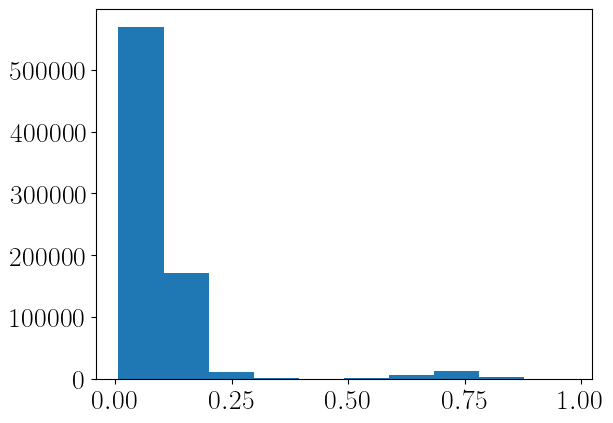

In [36]:
plt.hist(inter_dist_pos)
plt.show()

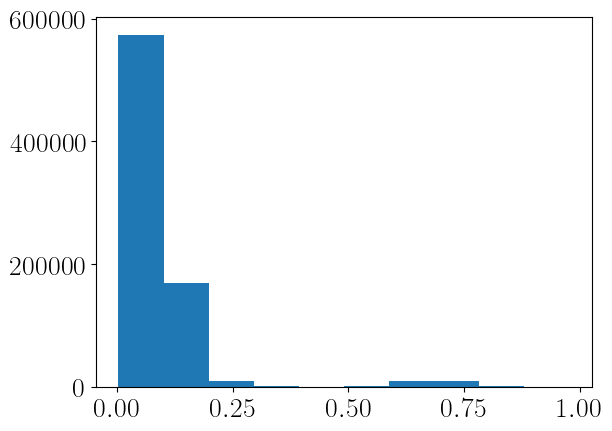

In [37]:
plt.hist(inter_dist_neg)
plt.show()

In [73]:
def compute_task_hardness_molecule_intra(distance_list: List[np.ndarray]) -> List:
    """Computes the task hardness for each task in the dataset.
    We have a list of arrays, where each element of the list is a N_pos*N_neg array where N_pos is the number of positives
    and N_neg is the number of negatives. Each element of the array is the tanimoto similarity between a positive and a negative.
    
    Higher Tanimoto similarity means harder thet task.
    Args:
        distance_list: List of N_pos*N_neg array where each array is tanimoto similarity between positives and negatives.

    """
    
    task_hardness = [item.max(axis=1).mean() for item in distance_list]
    return task_hardness

In [74]:
import heapq
def compute_task_hardness_molecule_inter(distance_list: List[np.ndarray], test_size=157, train_size=4938, topk=100) -> List:
    """Computes the task hardness for each task in the dataset.
    We have a list of arrays, where each element of the list is a N_pos*N_neg array where N_pos is the number of positives
    and N_neg is the number of negatives. Each element of the array is the tanimoto similarity between a positive and a negative.
    
    Higher Tanimoto similarity means harder thet task.
    Args:
        distance_list: List of N_pos*N_neg array where each array is tanimoto similarity between positives and negatives.

    """
    distance  = []
    for i in range(test_size):
        d = heapq.nlargest(topk, distance_list[i*train_size : i*train_size+train_size])
        distance.append(1 - np.array(d).mean())
    
    return distance

In [75]:
inter_dist_pos_per_task = compute_task_hardness_molecule_inter(inter_dist_pos)
#inter_dist_neg_per_task = compute_task_hardness_molecule_inter(inter_dist_neg)

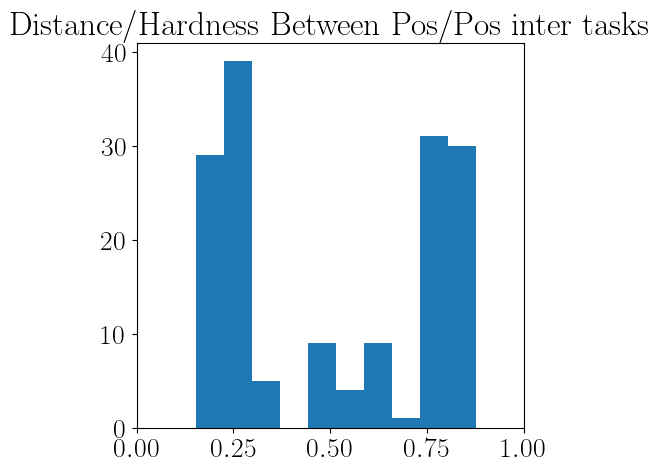

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(inter_dist_pos_per_task)
ax.set_title("Distance/Hardness Between Pos/Pos inter tasks")
ax.set_xlim(0.0, 1.0)
plt.show()

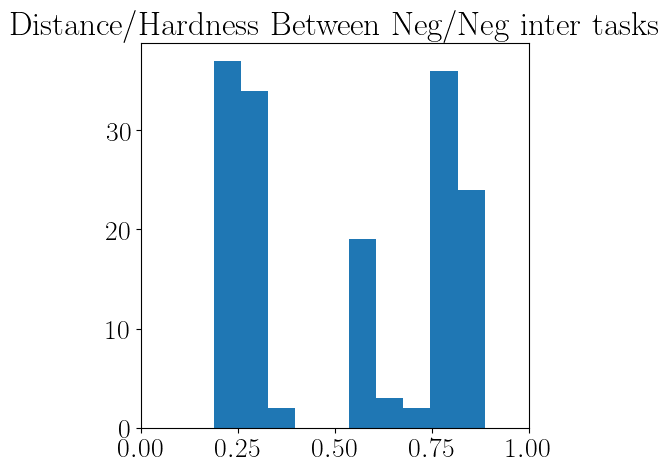

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(inter_dist_neg_per_task)
ax.set_title("Distance/Hardness Between Neg/Neg inter tasks")
ax.set_xlim(0.0, 1.0)
plt.show()

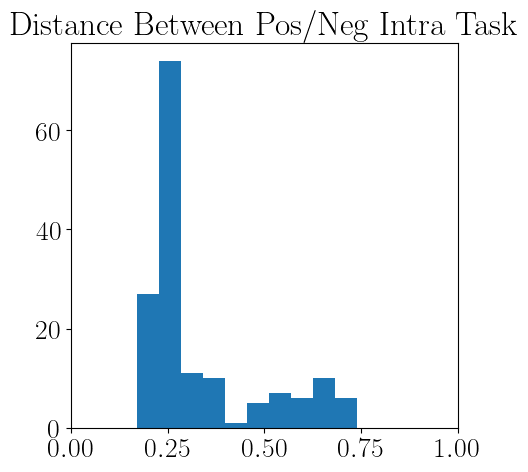

In [45]:
hardness_molecule_intra = compute_task_hardness_molecule_intra(intra_dist)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(hardness_molecule_intra)
ax.set_title("Distance Between Pos/Neg Intra Task")
ax.set_xlim(0.0, 1.0)
plt.show()

## Task Hardness Plot and Visualization

In [2]:
evaluation_output_directory = os.path.join(FS_MOL_CHECKOUT_PATH, "outputs", "FSMol_Eval_ProtoNet_2023-02-15_12-21-54")
output_results = pd.read_csv(os.path.join(evaluation_output_directory, "summary", "ProtoNet_summary_num_train_requested_128.csv"))

In [47]:
test_tasks_assay_name = [task.name for task in test_tasks]
intra_hardness_df = pd.DataFrame({'assay': test_tasks_assay_name, 'intra_molecule_hardness': hardness_molecule_intra})
inter_hardness_df = pd.DataFrame({'assay': test_tasks_assay_name, 'inter_molecule_hardness': inter_dist_pos_per_task, \
                                  'inter_molecule_hardness_neg': inter_dist_neg_per_task})

In [48]:
hardness_df = pd.merge(intra_hardness_df, inter_hardness_df, on="assay")
hardness_df = pd.merge(hardness_df, protein_hardness_df, on="assay")

In [50]:
dummy = output_results[['assay', 'delta_auprc', 'roc_auc']]
hardness_perf_df = pd.merge(hardness_df, dummy, on="assay")

In [13]:
# if we want just to read hardness from the file that has been created
hardness_perf_df = pd.read_csv('tmp/hardness_perf_df.csv')

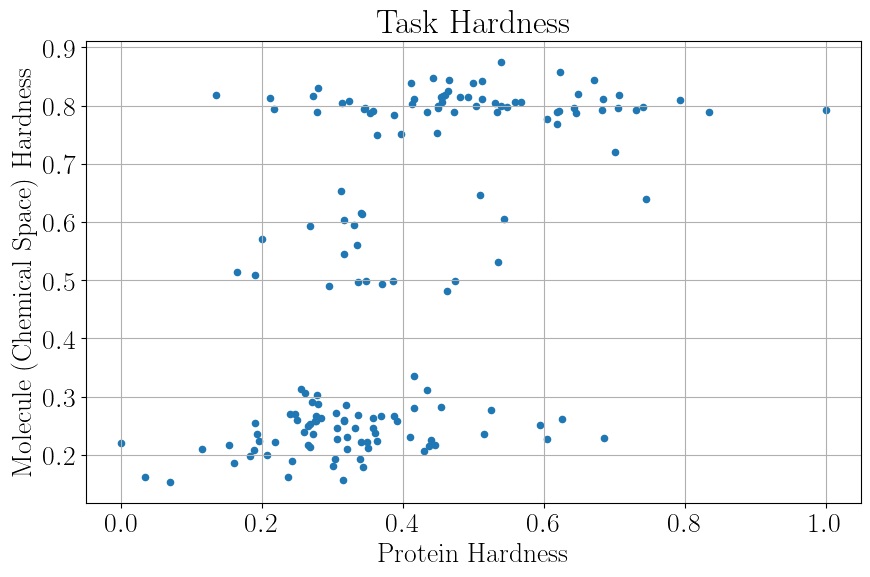

In [19]:
x = hardness_perf_df.protein_hardness_mean_norm.values
z = hardness_perf_df.inter_molecule_hardness.values

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(x, z, s=20)
ax.set_title("Task Hardness")
ax.set_xlabel("Protein Hardness")
ax.set_ylabel("Molecule (Chemical Space) Hardness")
ax.grid(True)

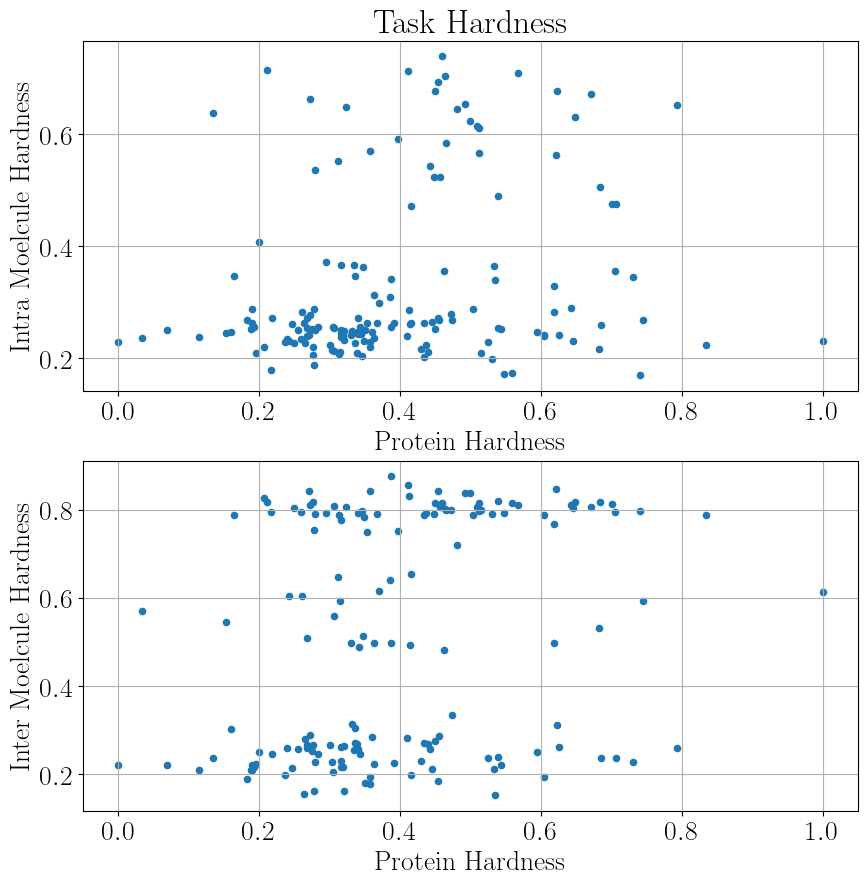

In [51]:
x = hardness_perf_df.protein_hardness_mean_norm.values
y = hardness_perf_df.intra_molecule_hardness.values
z = hardness_perf_df.inter_molecule_hardness.values

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].scatter(x, y, s=20)
ax[0].set_title("Task Hardness")
ax[0].set_xlabel("Protein Hardness")
ax[0].set_ylabel("Intra Moelcule Hardness")
ax[0].grid(True)

ax[1].scatter(x, z, s=20)
ax[1].set_xlabel("Protein Hardness")
ax[1].set_ylabel("Inter Molecule Hardness")
ax[1].grid(True)


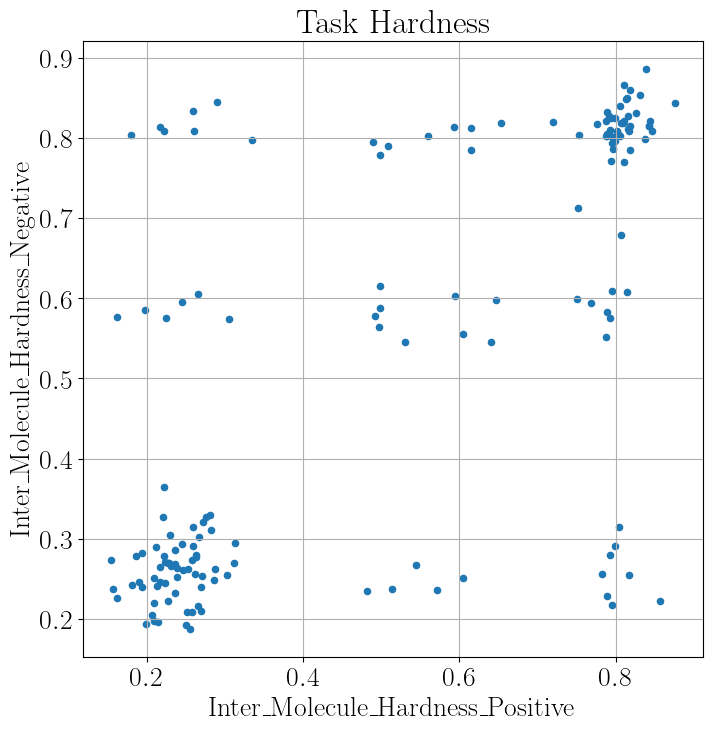

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(hardness_perf_df['inter_molecule_hardness'], hardness_perf_df['inter_molecule_hardness_neg'], s=20)
ax.set_title("Task Hardness")
ax.set_xlabel("Inter_Molecule_Hardness_Positive")
ax.set_ylabel("Inter_Molecule_Hardness_Negative")
ax.grid(True)

In [55]:
import plotly.express as px
hardness_perf_df['hardness1'] = hardness_perf_df['protein_hardness_mean_norm'] + hardness_perf_df['intra_molecule_hardness']
hardness_perf_df['hardness2'] = hardness_perf_df['protein_hardness_mean_norm'] + hardness_perf_df['inter_molecule_hardness']
hardness_perf_df['hardness3'] = hardness_perf_df['protein_hardness_mean_norm'] + hardness_perf_df['inter_molecule_hardness_neg']

In [56]:
fig = px.scatter(hardness_perf_df, x='protein_hardness_mean', y='intra_molecule_hardness', \
           hover_data='assay')
fig.update_layout(
    font_family="serif",
    font_color="blue",
    title_font_family="Computer Modern Roman",
    title_font_color="red",
    legend_title_font_color="green"
)

fig.show()


In [57]:
fig = px.scatter(hardness_perf_df, x='protein_hardness_mean', y='inter_molecule_hardness', \
           hover_data='assay')
fig.update_layout(
    font_family="serif",
    font_color="blue",
    title_font_family="Computer Modern Roman",
    title_font_color="red",
    legend_title_font_color="green"
)

fig.show()

In [58]:
fig = px.scatter(hardness_perf_df, x='protein_hardness_mean', y='inter_molecule_hardness_neg', \
           hover_data='assay')
fig.update_layout(
    font_family="serif",
    font_color="blue",
    title_font_family="Computer Modern Roman",
    title_font_color="red",
    legend_title_font_color="green"
)

fig.show()

## Correlation Between Task Hardness and Test Set Performance

Here we show the correlation between task hardness and test set performance. We can see that the correlation is not very strong, but there is a trend that harder tasks are more difficult to predict.

In [59]:
corr1 = hardness_perf_df['protein_hardness_mean_norm'].corr(hardness_perf_df['roc_auc'], method='pearson')
corr2 = hardness_perf_df['intra_molecule_hardness'].corr(hardness_perf_df['roc_auc'], method='pearson')
corr3 = hardness_perf_df['inter_molecule_hardness'].corr(hardness_perf_df['roc_auc'], method='pearson')
corr4 = hardness_perf_df['inter_molecule_hardness_neg'].corr(hardness_perf_df['roc_auc'], method='pearson')
corr5 = hardness_perf_df['hardness1'].corr(hardness_perf_df['roc_auc'], method='pearson')
corr6 = hardness_perf_df['hardness2'].corr(hardness_perf_df['roc_auc'], method='pearson')
corr7 = hardness_perf_df['hardness3'].corr(hardness_perf_df['roc_auc'], method='pearson')

In [60]:
corr1, corr2, corr3, corr4, corr5, corr6, corr7

(-0.4386816450611648,
 -0.03356970194803391,
 -0.13345287893746677,
 -0.12497200628401119,
 -0.3105533409481725,
 -0.3118676271139563,
 -0.3062752820535091)

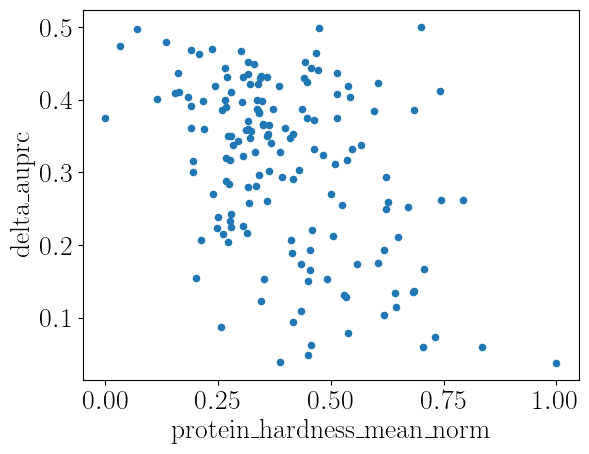

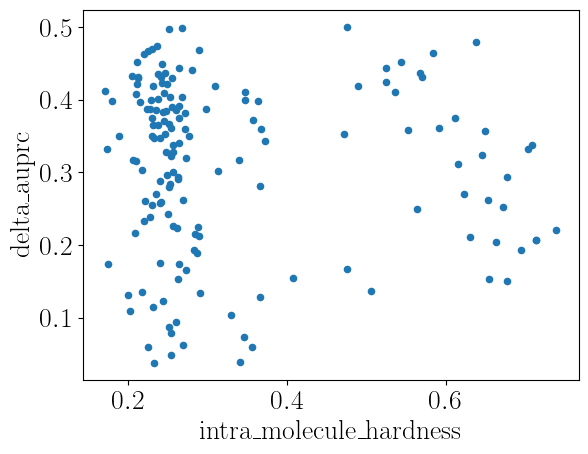

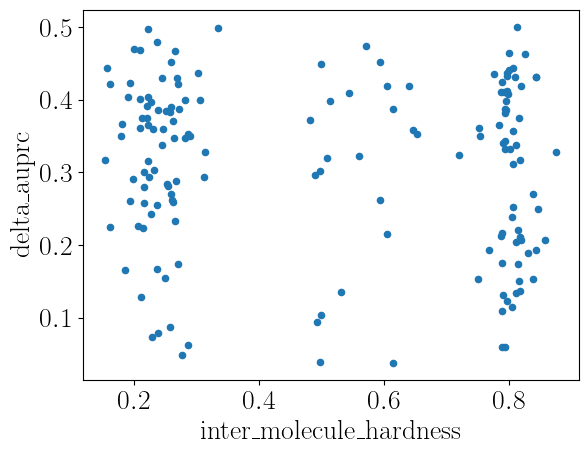

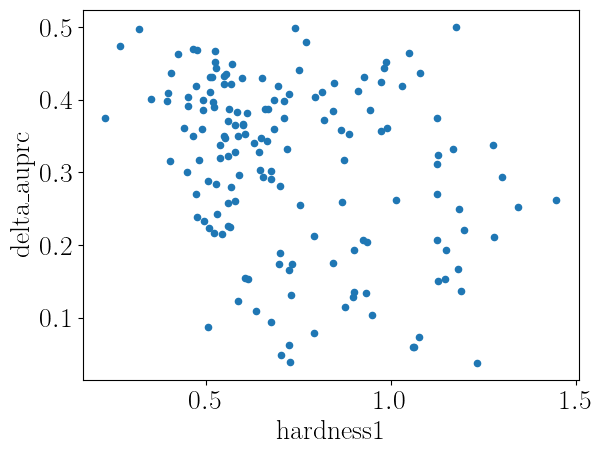

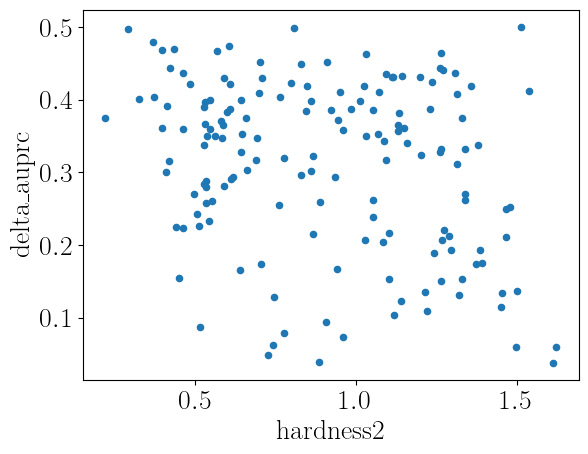

In [61]:
hardness_perf_df.plot.scatter(x='protein_hardness_mean_norm', y='delta_auprc')
hardness_perf_df.plot.scatter(x='intra_molecule_hardness', y='delta_auprc')
hardness_perf_df.plot.scatter(x='inter_molecule_hardness', y='delta_auprc')
hardness_perf_df.plot.scatter(x='hardness1', y='delta_auprc')
hardness_perf_df.plot.scatter(x='hardness2', y='delta_auprc')

plt.show()

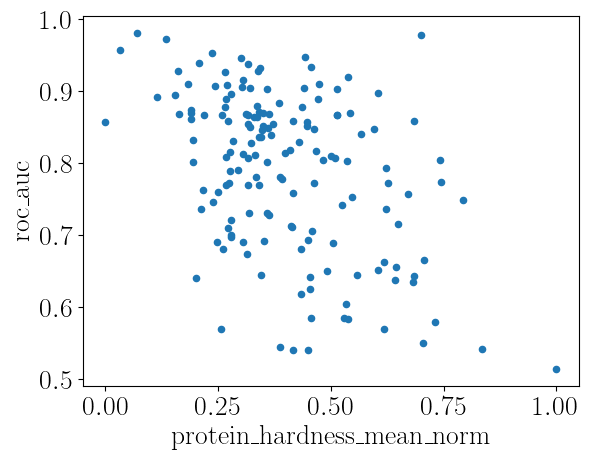

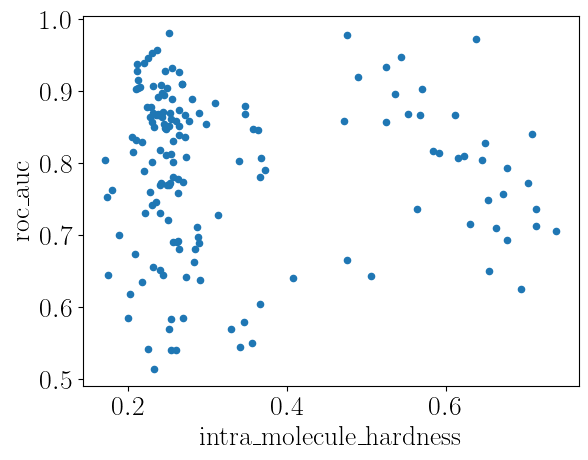

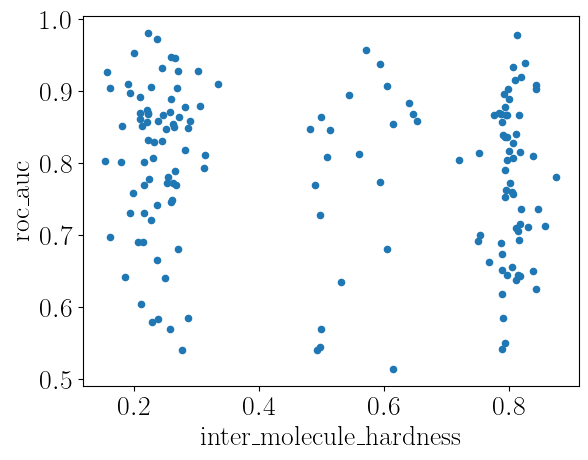

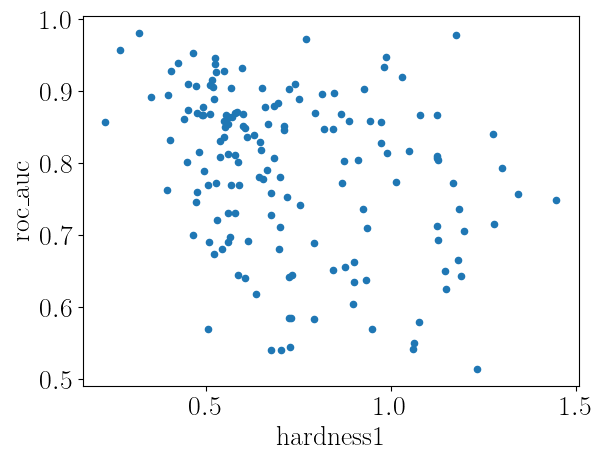

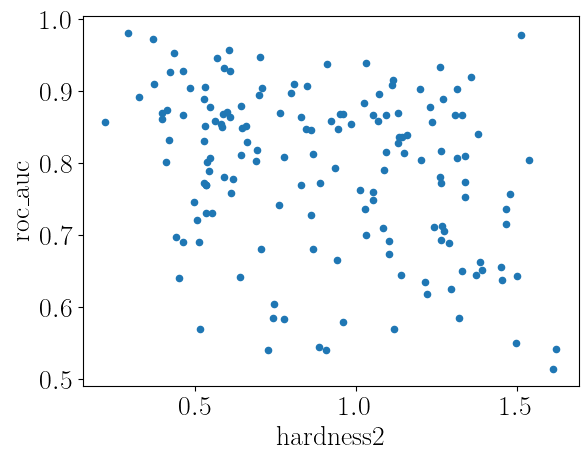

In [62]:
hardness_perf_df.plot.scatter(x='protein_hardness_mean_norm', y='roc_auc')
hardness_perf_df.plot.scatter(x='intra_molecule_hardness', y='roc_auc')
hardness_perf_df.plot.scatter(x='inter_molecule_hardness', y='roc_auc')
hardness_perf_df.plot.scatter(x='hardness1', y='roc_auc')
hardness_perf_df.plot.scatter(x='hardness2', y='roc_auc')

plt.show()

In [79]:
def compute_correlation(task_df_with_perf, col1, col2, method='pearson'):
    """Computes the correlation between two columns of a dataframe.
    
    Args:
        task_df_with_perf: Dataframe with the performance of the tasks. It should also
        contain the hardness of the tasks.
        col1: First column name (usually a measure of task hardness).
        col2: Second column name (usually a performance measure of a task).
        method: Correlation method to use.
    """
    corr = task_df_with_perf[col1].corr(task_df_with_perf[col2], method=method)
    return corr

In [104]:
# Correlation between protein hardness and delta_auprc for different k (nearest neighbors)
k = [1, 10, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 4000, 4500]
protein_hardness_diff_k = {}
corr_list = []
for item in k:
    hardness_protien = compute_task_hardness_protein(train_test_dist_L2, k=item)
    hardness_protein_norm = (hardness_protien[0].numpy()-np.min(hardness_protien[0].numpy()))/(np.max(hardness_protien[0].numpy())-np.min(hardness_protien[0].numpy()))
    protein_hardness_diff_k['k' + str(item)] = hardness_protein_norm
    protein_hardness_diff_k['assay'] = a

protein_hardness_diff_k_df = pd.DataFrame(protein_hardness_diff_k)

In [105]:
z = pd.merge(dummy, protein_hardness_diff_k_df, on="assay")
for item in k:
    corr_list.append(compute_correlation(z, 'k' + str(item), 'roc_auc'))

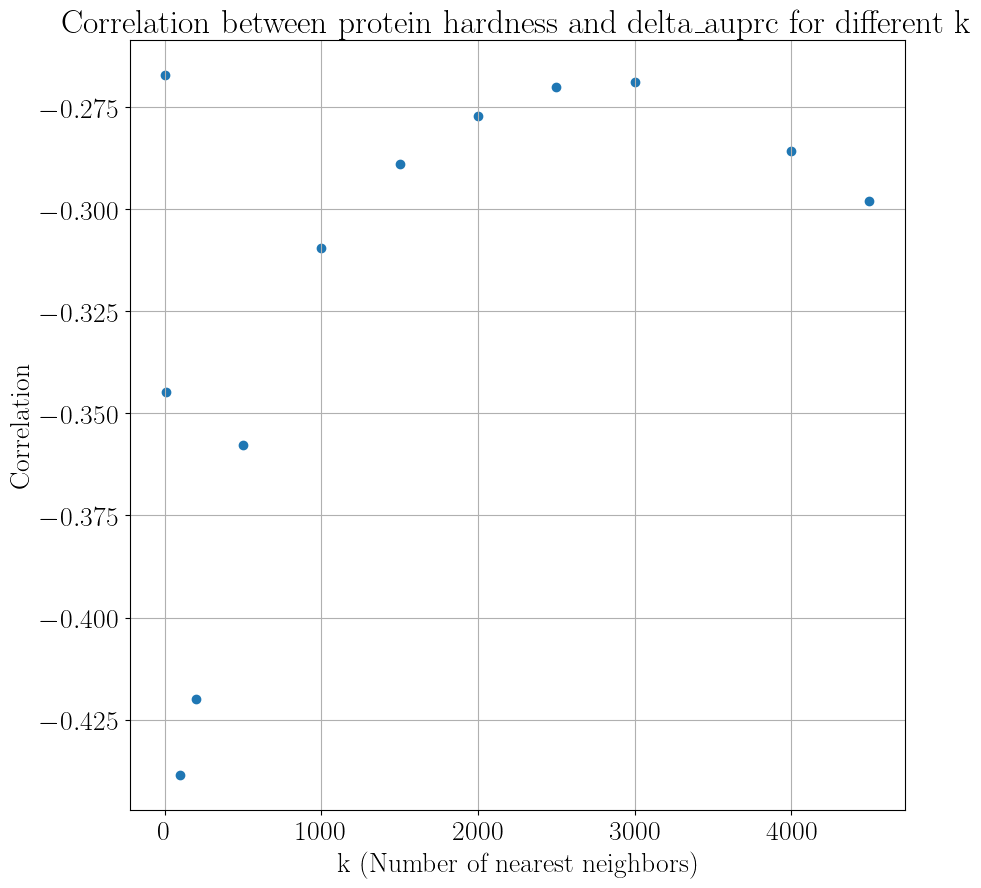

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(k, corr_list, marker='o')
ax.set_title('Correlation between protein hardness and delta_auprc for different k')
ax.set_xlabel('k (Number of nearest neighbors)')
ax.set_ylabel('Correlation')
ax.grid()
plt.show()


## Corrrelation Between Inter Task Hardness and Test Set Performance

In [40]:
dummy = output_results[['assay', 'delta_auprc', 'roc_auc']]
m = pd.merge(inter_hardness_df, dummy, on="assay")

In [42]:
m['inter_molecule_hardness'].corr(m['delta_auprc'], method='pearson')

-0.39045987409316074

In [93]:
# Correlation between protein hardness and delta_auprc for different k (nearest neighbors)
k = [1, 10, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 4000, 4500]
inter_hardness_diff_k = {}
corr_list = []
for item in k:
    inter_hard = compute_task_hardness_molecule_inter(inter_dist_pos, topk=item)
    inter_hardness_diff_k['k' + str(item)] = inter_hard
    inter_hardness_diff_k['assay'] = test_tasks_assay_name

inter_hardness_diff_k_df = pd.DataFrame(inter_hardness_diff_k)

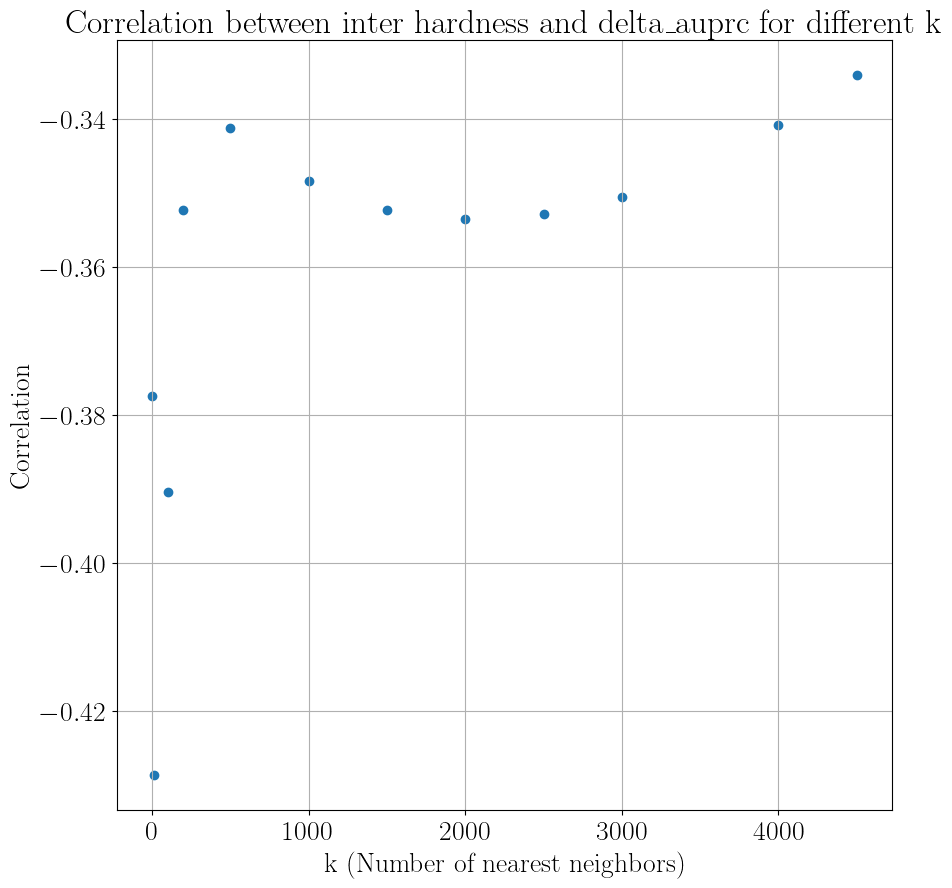

In [94]:
z = pd.merge(dummy, inter_hardness_diff_k_df, on="assay")
for item in k:
    corr_list.append(compute_correlation(z, 'k' + str(item), 'delta_auprc'))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(k, corr_list, marker='o')
ax.set_title('Correlation between inter hardness and delta_auprc for different k')
ax.set_xlabel('k (Number of nearest neighbors)')
ax.set_ylabel('Correlation')
ax.grid()
plt.show()

## Simple Linear Regression Model For Predicting Test Set Performance

Coefficients: 
 [-0.16329797 -0.1463342 ]
Mean squared error: 0.01
Coefficient of determination: 0.19


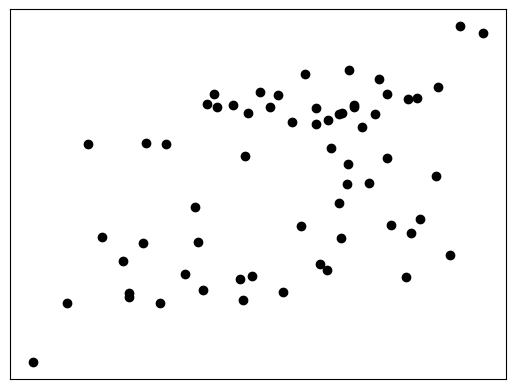

In [110]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = hardness_perf_df[['protein_hardness_mean_norm', 'inter_molecule_hardness']]
y = hardness_perf_df['delta_auprc']
 
# Separating the data into independent and dependent variables
# Converting each dataframe into a numpy array

 
# Dropping any rows with Nan values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)
 
# Splitting the data into training and testing data
regr = LinearRegression()
 
regr.fit(X_train, y_train)


# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


# Plot outputs
plt.scatter(y_test, y_pred, color="black")

plt.xticks(())
plt.yticks(())

plt.show()


In [78]:
xx = inter_hardness_df = pd.DataFrame({'assay': test_tasks_assay_name, 'inter_molecule_hardness': inter_dist_pos_per_task})

In [86]:
dict = {}
for i in range(157):
    a = test_tasks_assay_name[i]
    b = inter_dist_pos[i*4934 : i*4938+4938]
    dict[a] = b
    

In [95]:
import pickle
with open('tmp/inter_dist_pos_pos.pkl', 'wb') as f:
    pickle.dump(dict, f)

In [4]:
import pandas as pd
df = pd.read_csv('tmp/hardness_perf_df.csv')

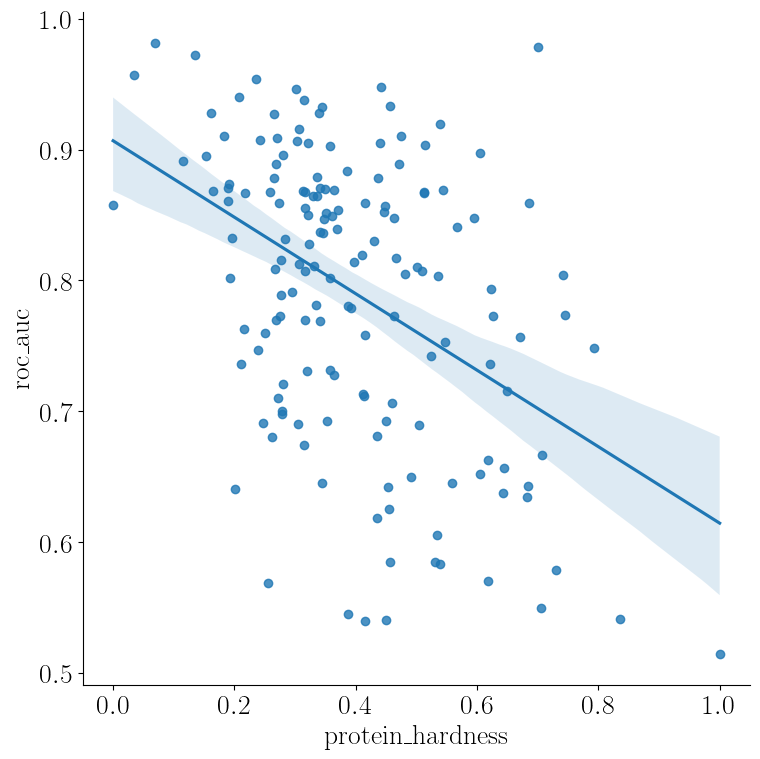

In [12]:
import seaborn as sns

ax = sns.lmplot(x="protein_hardness_mean_norm", y="roc_auc",data=df, height=8)
ax.set(xlabel='protein_hardness')
plt.show()

In [17]:
hard = pd.read_csv('datasets/test/hardness/desc2D_pos.csv')
hard.columns = ['assay', 'hardness']
hard


,assay,hardness
0,CHEMBL1066254,70.121210
1,CHEMBL1006005,62.551647
2,CHEMBL1613926,95.413440
3,CHEMBL1613907,74.939200
4,CHEMBL1613898,41.316483
...,...,...
152,CHEMBL1613800,NaN
153,CHEMBL1794324,NaN
154,CHEMBL1614027,NaN
155,CHEMBL1614153,NaN


In [18]:
x = pd.merge(output_results[['assay', 'delta_auprc', 'roc_auc']], hard, on="assay")

In [ ]:
import seaborn as sns

ax = sns.lmplot(x="hardness", y="roc_auc",data=x, height=5)
ax.set(xlabel='chemical space hardness')
plt.show()

In [25]:
x['hardness'].corr( x['roc_auc'])

-0.06766374738129027